In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd "/content/drive/MyDrive/Colab Notebooks/chet-Xray"

/content/drive/MyDrive/Colab Notebooks/chet-Xray


In [4]:
# Check tensorflow version and GPU availability
import tensorflow as tf
print('tf version:', tf.__version__)
print('gpu:', tf.config.list_physical_devices('GPU'))

tf version: 2.6.0
gpu: []


In [5]:
!pip install opencv-python

In [6]:
import cv2

In [7]:
IMG_DIMEN = 224
N_COLORS = 3

In [8]:
from tqdm import tqdm
import numpy as np
import os

def read_data(dir_path):
    X = []
    y = []
    y_map = {'NORMAL': 0, 'PNEUMONIA': 1}
    for class_name in y_map.keys():
        subdir_path = os.path.join(dir_path, class_name)
        filenames = os.listdir(subdir_path)
        for fname in tqdm(filenames):
            if fname.endswith('.jpeg'):
                img_path = os.path.join(subdir_path, fname)
                img = cv2.imread(img_path)
                img = cv2.resize(img, dsize=(IMG_DIMEN, IMG_DIMEN))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img.reshape((1, IMG_DIMEN, IMG_DIMEN, N_COLORS))
                X.append(img)
                y.append(y_map[class_name])
    X = np.vstack(X).astype('float32')/255.0
    y = np.array(y).astype('int32')
    return X, y

In [9]:
X, y = read_data('data/train')

100%|██████████| 3883/3883 [25:48<00:00,  2.51it/s]


In [10]:
print(X.shape)
print(y.shape)

(5232, 224, 224, 3)
(5232,)


In [11]:
X_test, y_test = read_data('data/test')

100%|██████████| 390/390 [02:07<00:00,  3.05it/s]


In [12]:
print(X_test.shape)
print(y_test.shape)

(624, 224, 224, 3)
(624,)


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=0)

In [14]:
print(X_train.shape)
print(y_train.shape)
print('--------------')
print(X_val.shape)
print(y_val.shape)

(3505, 224, 224, 3)
(3505,)
--------------
(1727, 224, 224, 3)
(1727,)


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    plt.figure(figsize=(6, 6))
    if N_COLORS == 3:
        plt.imshow(img)
    elif N_COLORS == 1:
         plt.imshow(img, cmap='gray')
    plt.show()

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Dense

In [17]:
pretrained_model = MobileNet(
    include_top=False,
    input_shape=(IMG_DIMEN, IMG_DIMEN, N_COLORS), 
    pooling='avg', 
)

pretrained_model.trainable = False


model = Sequential()
model.add(pretrained_model)
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

17235968/17225924 [==============================] - 0s 0us/step


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,025
Non-trainable params: 3,228,864
_________________________________________________________________


In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'saved-model-mobilenet/best-model', monitor='val_loss', mode='min', 
    save_weights_only=True, save_best_only=True, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=20,
    callbacks=[checkpoint]
)

Epoch 1/20
110/110 [==============================] - 142s 1s/step - loss: 0.2944 - accuracy: 0.8762 - val_loss: 0.1792 - val_accuracy: 0.9259

Epoch 00001: val_loss improved from inf to 0.17922, saving model to saved-model-mobilenet/best-model
Epoch 2/20
110/110 [==============================] - 140s 1s/step - loss: 0.1460 - accuracy: 0.9489 - val_loss: 0.1427 - val_accuracy: 0.9490

Epoch 00002: val_loss improved from 0.17922 to 0.14268, saving model to saved-model-mobilenet/best-model
Epoch 3/20
110/110 [==============================] - 141s 1s/step - loss: 0.1129 - accuracy: 0.9621 - val_loss: 0.1097 - val_accuracy: 0.9589

Epoch 00003: val_loss improved from 0.14268 to 0.10971, saving model to saved-model-mobilenet/best-model
Epoch 4/20
110/110 [==============================] - 140s 1s/step - loss: 0.0986 - accuracy: 0.9663 - val_loss: 0.1046 - val_accuracy: 0.9606

Epoch 00004: val_loss improved from 0.10971 to 0.10462, saving model to saved-model-mobilenet/best-model
Epoch 5/

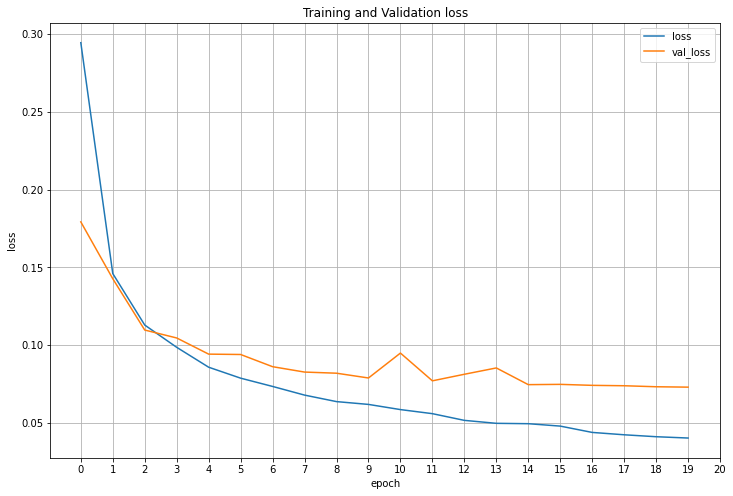

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

hist_df = pd.DataFrame(history.history)
hist_df.plot(y=['loss', 'val_loss'], figsize=(12, 8))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and Validation loss')
plt.grid(axis='both')
plt.xticks(np.arange(0, 21, 1))
plt.show()

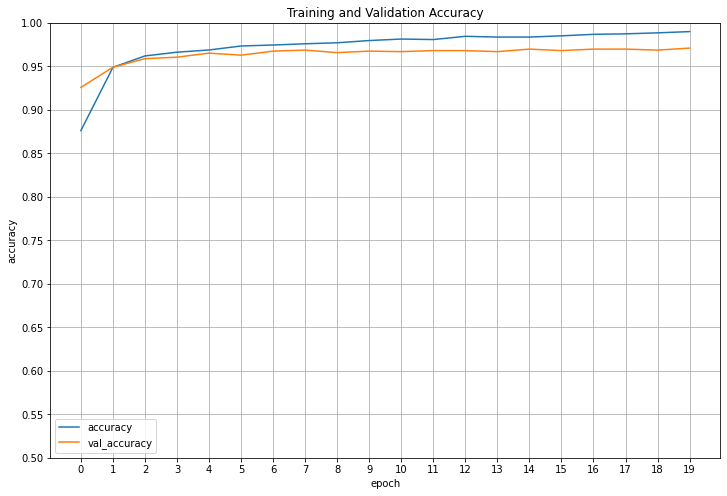

In [22]:
hist_df = pd.DataFrame(history.history)
hist_df.plot(y=['accuracy', 'val_accuracy'], figsize=(12, 8))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training and Validation Accuracy')
plt.grid(axis='both')
plt.xticks(np.arange(0, 20, 1))
plt.yticks(np.arange(0.5, 1.01, 0.05))
plt.show()

In [23]:
model.load_weights('saved-model-mobilenet/best-model')
model.evaluate(X_test, y_test)

20/20 [==============================] - 17s 846ms/step - loss: 0.5979 - accuracy: 0.8205


[0.5978759527206421, 0.8205128312110901]